In [191]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import warnings
import seaborn as sns
from scipy.stats import bartlett
from scipy.stats import levene
%matplotlib inline
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [172]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


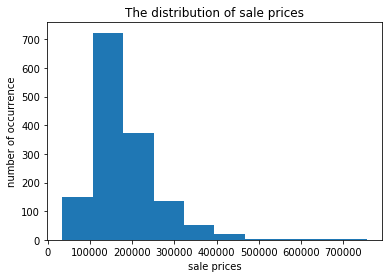

In [122]:
plt.hist(df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

In [120]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


In [48]:
df.info()
# df['lotfrontage'].dtypes == np.float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [109]:
# Here I'm splitting the db into numerical, numerical (that I consider categorical), and non-numerical categorical

df_num = df.select_dtypes(include=['int64', 'float64'])
dropc = ['id', 'yrsold', 'overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'mosold']
df3 = df.loc[:, dropc]
df_obj = df.select_dtypes(include=['object'])

# Here I'm dropping any int/float fields I consider to be categorical and not fit for a scatterplot. I'll us a bar plot for those
df2 = df_num.drop(dropc, axis = 1)
df3 = df3.drop('id', axis = 1)

print(len(df3.columns))
df3.info()
# print(df3.head())

13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
yrsold          1460 non-null int64
overallqual     1460 non-null int64
overallcond     1460 non-null int64
bsmtfullbath    1460 non-null int64
bsmthalfbath    1460 non-null int64
fullbath        1460 non-null int64
halfbath        1460 non-null int64
bedroomabvgr    1460 non-null int64
kitchenabvgr    1460 non-null int64
totrmsabvgrd    1460 non-null int64
fireplaces      1460 non-null int64
garagecars      1460 non-null int64
mosold          1460 non-null int64
dtypes: int64(13)
memory usage: 148.4 KB


In [118]:
np.abs(df_num.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)
# overallqual, grlivarea, garagecars, garagearea, totalbsmtsf

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Here we see the numeric features most correlated with the target variable. None of the top 5 features seem to be missing a lot of values (refer to the list of features with missing values above). Below we'll visualize these relationships.

Numerical Features vs. Target Variable


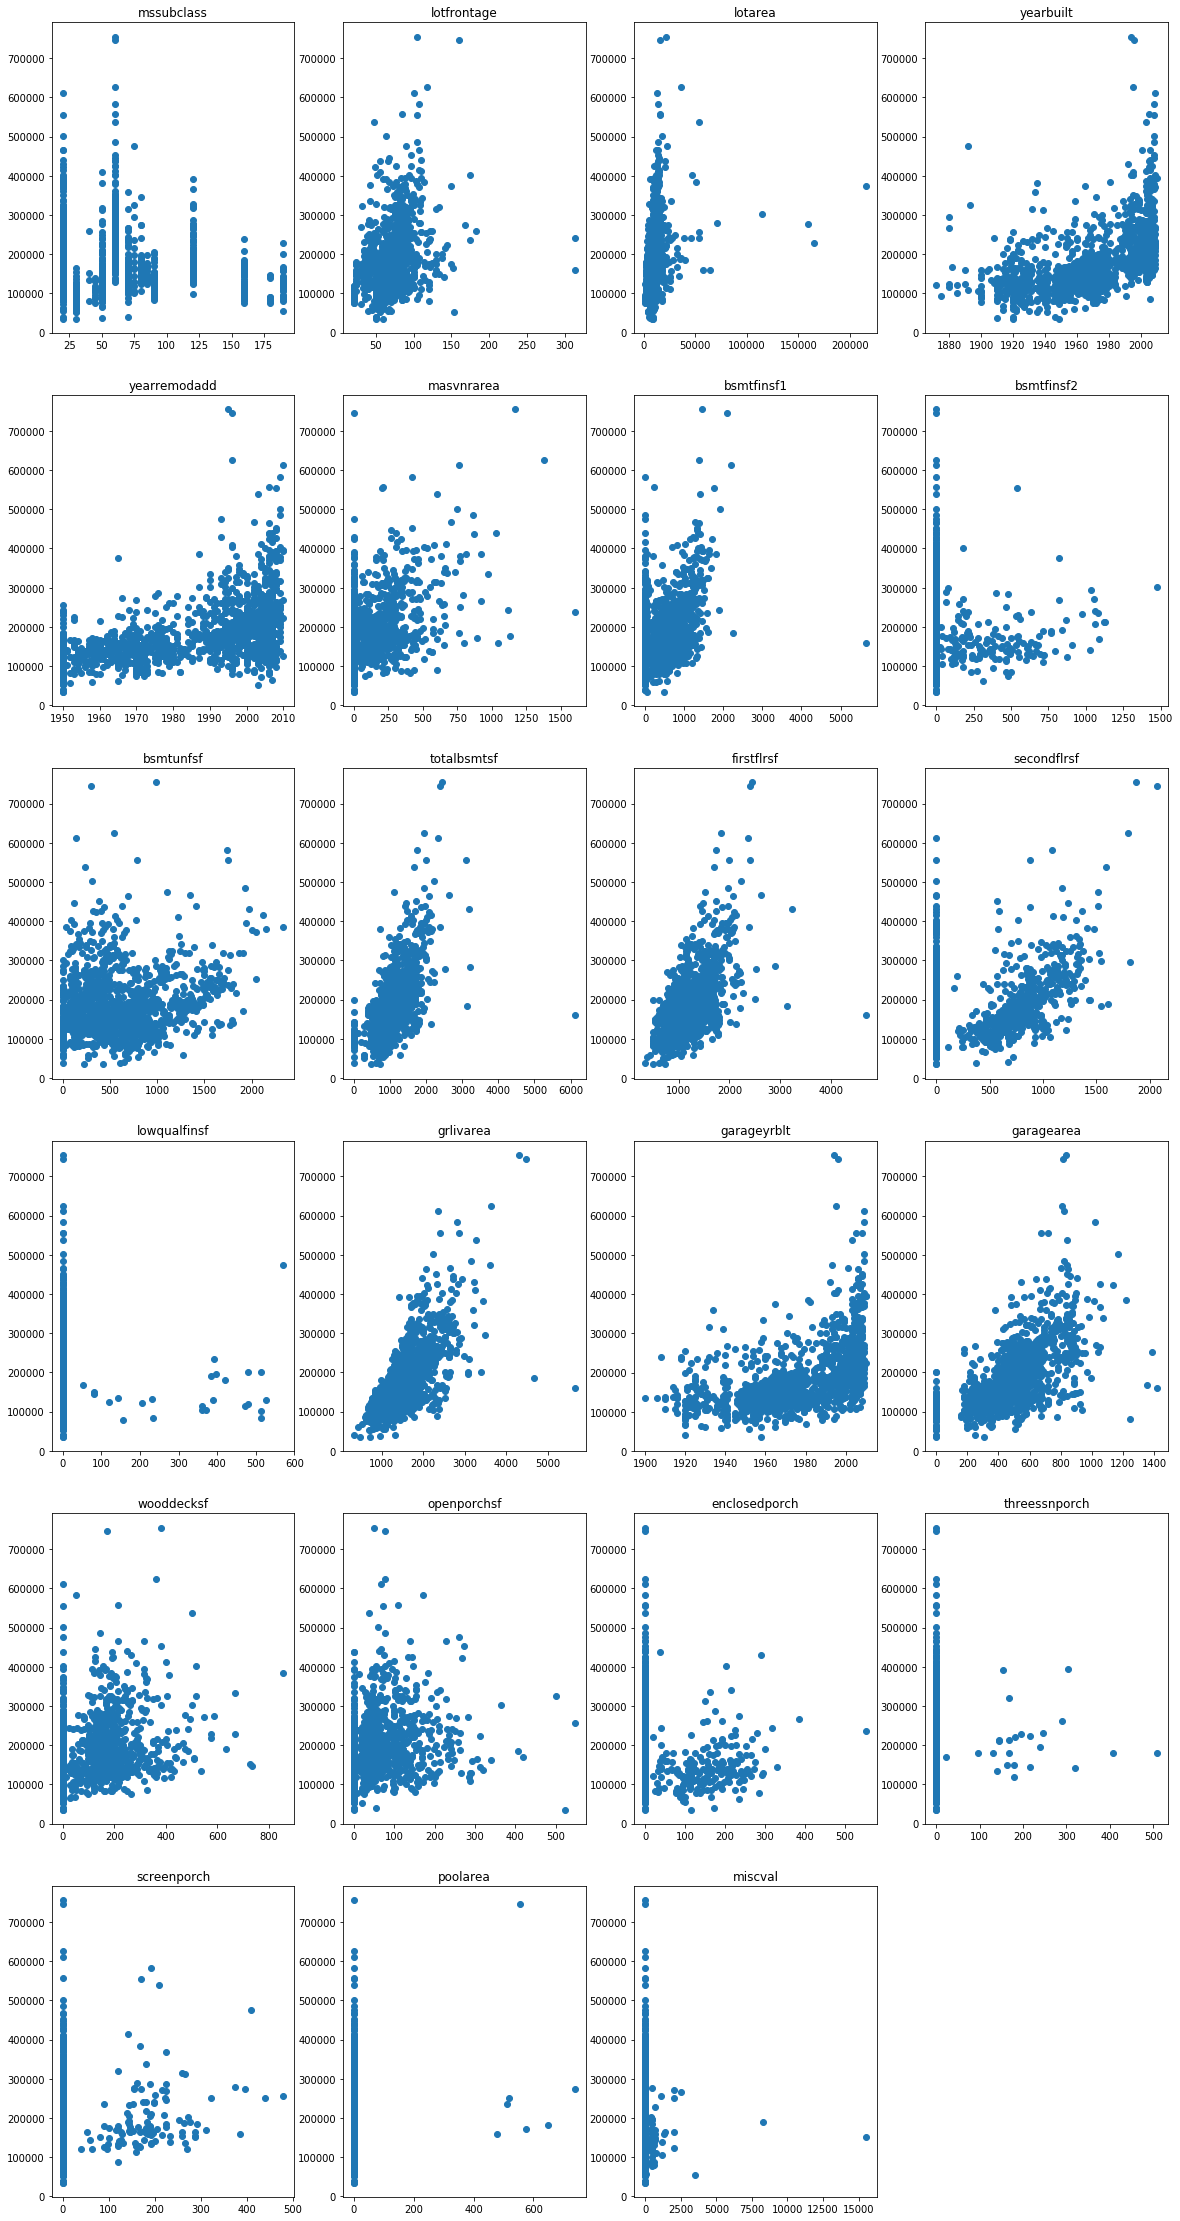

In [101]:
columns = df2.columns.unique()
plt.figure(figsize=(20, 40))

print('Numerical Features vs. Target Variable')
for i in range(1, len(columns)):
    plt.subplot(6, 4, i)
    plt.scatter(x=df[columns[i - 1]], y=df['saleprice'])
    plt.title(columns[i - 1])

plt.show()

Categorical Features vs. Target Variable


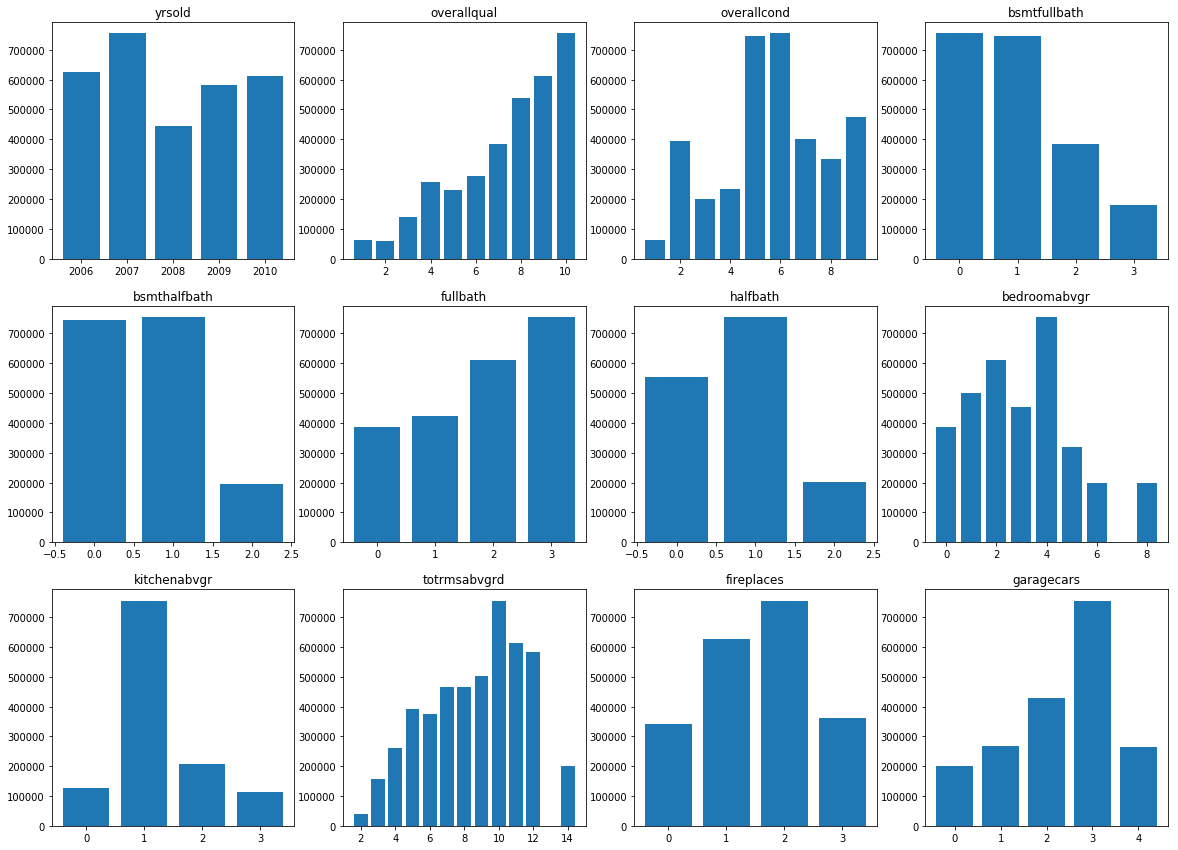

In [117]:
columns2 = df3.columns.unique()
plt.figure(figsize=(20, 20))

print('Categorical Features vs. Target Variable')
for i in range(1, len(columns2)):
    plt.subplot(4, 4, i)
    plt.bar(df[columns2[i - 1]], df['saleprice'])
    plt.title(columns2[i - 1])

plt.show()

Below we take a look at the categorical variables and how they relate to sales price. Mszonging and street stick out as two that could be of use. I'll take those two along with the top 5 numerical varialbles (overallqual, grlivarea, garagecars, garagearea, and totalbsmtsf)

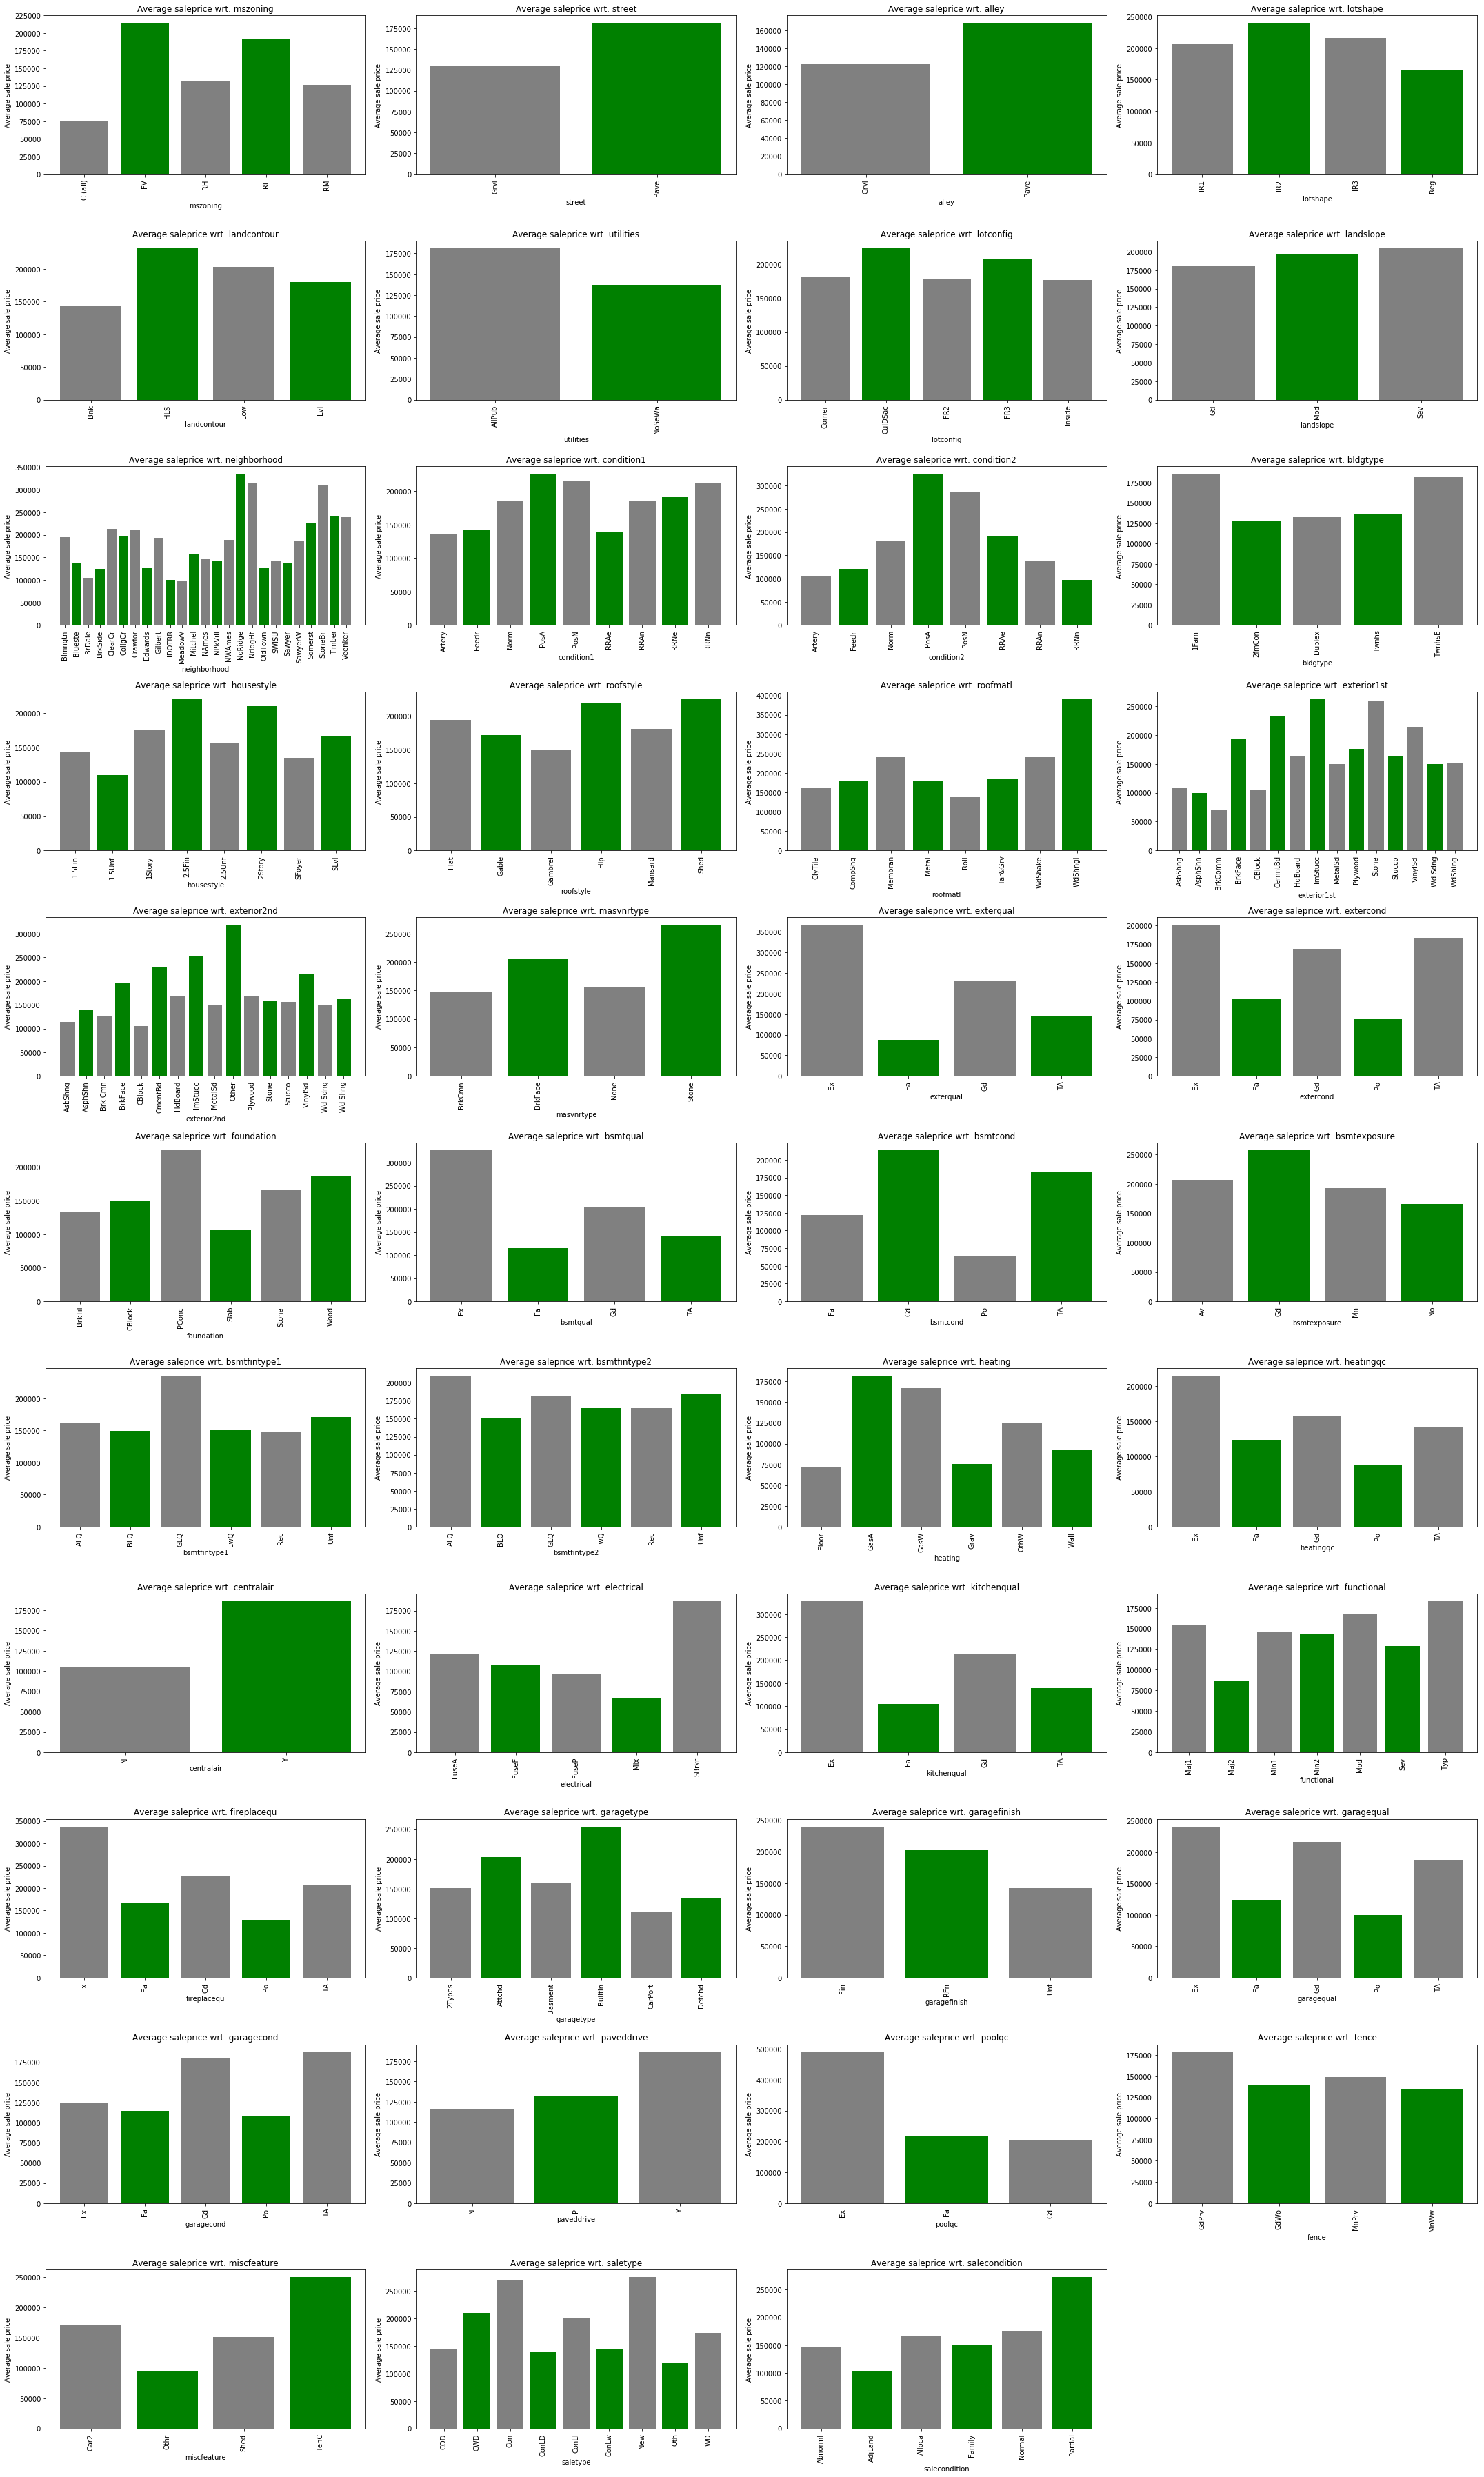

In [130]:
obj_col = df_obj.columns.unique()

plt.figure(figsize=(30,50))

for index, column in enumerate(obj_col):
    plt.subplot(11,4,index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [181]:
df = pd.concat([df,pd.get_dummies(df['mszoning'], prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

print(dummy_column_names)

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'street_Pave']


In [182]:
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

Y = df.saleprice

In [183]:
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

Y = df.saleprice

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:24:01   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual  2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea      45.6344      2.468     18.494      0.000      40.794      50.475
garagecars   1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea     16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf    28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV  8362.5046   4562.459      1.833      0.067    -587.226    1.73e+04
mszoning_FV  8362.5046   4562.459      1.833      0.067    -587.226    1.73e+04
mszoning_FV  8362.5046   4562.459      1.833      0.067    -587.226    1.73e+04
mszoning_RH  4473.4855   5282.272      0.847      0.397   -5888.232    1.48e+04
mszoning_RH  4473.4855   5282.272      0.847      0.397   -5888.232    1.48e+04
mszoning_RH  4473.4855   5282.272      0.847      0.397   -5888.232    1.48e+04
mszoning_RL  9521.9520   4240.253      2.246      0.025    1204.261    1.78e+04
mszoning_RL  9521.9520   4240.253      2.246      0.025    1204.261    1.78e+04
mszoning_RL  9521.9520   4240.253      2.246      0.025    1204.261    1.78e+04
mszoning_RM  3015.9298   4296.911      0.702      0.483   -5412.902    1.14e+04
mszoning_RM  3015.9298   4296.911      0.702      0.483   -5412.902    1.14e+04
mszoning_RM  3015.9298   4296.911      0.702      0.483   -5412.902    1.14e+04
street_Pave    50.3459   5430.500      0.009      0.993   -1.06e+04    1.07e+04
street_Pave    50.3459   5430.500      0.009      0.993   -1.06e+04    1.07e+04
street_Pave    50.3459   5430.500      0.009      0.993   -1.06e+04    1.07e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     4.17e+37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-66. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Assumption two: the error term should be zero on average

In [187]:
predictions = sm.OLS(Y, X).fit().predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.8468842289908088e-08


Assumption three: homoscedasticity

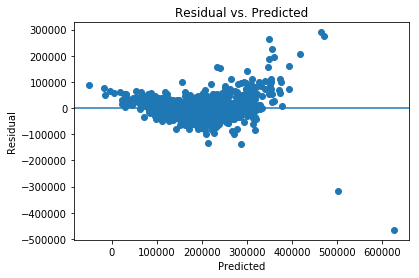

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


In [192]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Assumption four: low multicollinearity

In [ ]:
df.loc[:, features].corr()
print('None of the features are very correlated with each other. Windspeed and humidity are the more heavily correlated')

Assumption five: error terms should be uncorrelated with one another

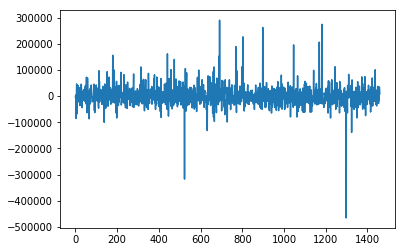

In [189]:
plt.plot(errors)
plt.show()

Assumption six: features shouldn't be correlated with the errors

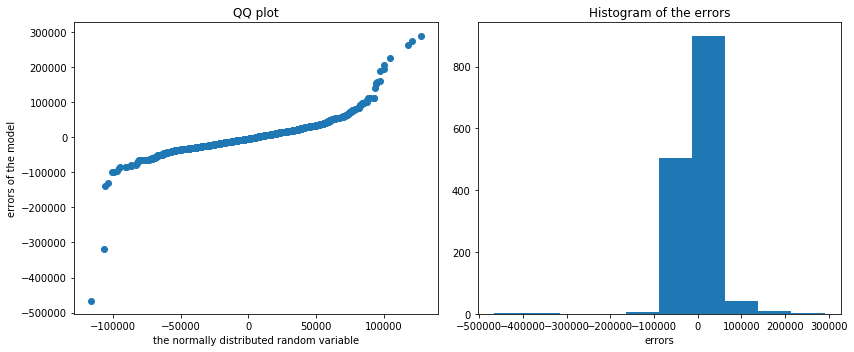

In [190]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()